In [5]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using LinearAlgebra, Plots
import MeshCat as mc 
using Test, Distributions
using Random
import ForwardDiff as FD 
using Interpolations   
import ECOS  
using ProgressMeter

  Activating environment at `~/CMU/24-774 Advanced Control Systems Integration/project/traj_gen/Project.toml`


In [12]:
include(joinpath(@__DIR__,"CrazyflieDynamics_noMagnet.jl"))
include(joinpath(@__DIR__,"convex_mpc.jl"))

convex_mpc

In [6]:
########## FUNCTIONS ###########

# converting from vector of vectors <-> matrix 
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end

# Controls equilibrium point
function controls_equilibrium(u0::Vector, X̄, model, ode; tol= 1e-6, max_iters= 100, verbose= false)::Vector{Vector{Float64}}

    "
        Determining the equilibrium point for controls at hover
            - use Newton's method (minimize over u for least squares cost)
            - initial guess= hover location for planar hexarotor ([(9.81*mass/n_inputs)*ones(n_inputs) for i = 1:(N-1)])
    " 

    # initialize U
    U = [zeros(eltype(u0), length(u0)) for i= 1:max_iters] #empty vector for Newton guesses
    U[1]= u0 #initialize with first guess (which is simply counteracting gravity (mg/n_inputs)


    for i = (1:max_iters-1)
        
        residual= (1/2) * (ode(model, X̄, U[i]))'* ode(model, X̄, U[i]) # least squares cost function
        δfδu= FD.jacobian(du -> ode(model, X̄, du), U[i]) # jacobian of f with respect to u

        ∇residual= (δfδu)' * ode(model, X̄, U[i]) # gradient of cost function- to solve for u, this should be zero
        ∇²residual= ((δfδu)' * δfδu) + 1e-4*(I(4)) # hessian (gauss newton version) of cost function 
        # regularization term to ensure full rank
        #println("rank hessian: ", rank(∇²residual))

        norm_residual= norm(residual)

        if verbose 
            print("iter: $i    |residual|: $norm_residual   \n")
        end

        # check against tol
        # if converged, return U[1:i]
        if norm_residual < tol
            return U[1:i]
        end

        Δu= ∇²residual\(-∇residual) # Newton step
        #println(Δu)

        # update U
        U[i+1]= U[i] + vec(Δu)
        #println(U[i+1])
    end
    error("Newton's method did not converge")
end

controls_equilibrium (generic function with 1 method)

In [7]:


#### MODEL PARAMETERS ####
Ixx= 15943.775 # in g*mm^2
Ixy= -0.105
Ixz= 5.143
Iyx= -0.105
Iyy= 15907.168
Iyz= -7.578e-6
Izx= 5.143
Izy= -7.578e-6
Izz= 30643.887
model = (mass= 32.499, # in grams
    #J= Diagonal([Ixx -Ixy -Ixz; -Iyx Iyy -Iyz; -Izx -Izy Izz]), #inertia matrix- determined from CAD
    J= Diagonal([Ixx, Iyy, Izz]),
    gravity= [0,0,-9810], # gravity in mm/sec^2
    L= 45.75185, # from center of quadrotor to propeller rotation axis (in mm)
    kf= 2.3, #1.9, # constant thrust coefficient
    km= 5.9645e-3, #8.06428e-5, # propeller drag coefficient
    dt= 0.01, # frequency
)
##########


#### PROBLEM DETAILS ####
# problem size 
nx = 12 # number of states
nu = 4 # number of controls

dt = model.dt
tf = 10 #seconds
t_vec = 0:dt:tf
N = length(t_vec)
N_mpc= 80 # MPC horizon
N_sim= N+ N_mpc 
t_vec_sim = 0:dt:((N_sim-1)*dt)
m= model.mass
kf= model.kf


println("N= ", N)
##########


#### EQUILIBRIUM POINT FOR HOVER ####

# hover state
X̄= [0.0; 0.0; 1.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0] #+ 0.0001*randn(nx) # add a little bit of noise to reduce numerical instabilities
# initial guess for control equilibrium point- I made this the hover thrust for the planar hexrotor
u0= [(9810*m/(nu)); (9810*m/(nu)); (9810*m/(nu)); (9810*m/(nu))] 
#u0= [0.0; 10.0; 0.0; 0.0; 0.0; 0.0] 

# control limits (crazyflie thrust limits- from datasheet)
#u_min= 1.0 * ones(nu) #9810
u_min= -3.8225*9810 * ones(nu) #9810
u_max= 3.8225 * 9810* ones(nu) #15.29 gram force  #0.15 Newtons      57.9 * ones(nu) #100, 250
U= controls_equilibrium(u0, X̄, model, quadrotor_dynamics, tol= 1e-6, max_iters= 100, verbose= true)
Ū= U[end] # control equilibrium point! will linearize around this point
println("U equilibrium point= ", Ū)
##########

#### LINEARIZATION ####
# calculate A and B matrices (jacobians of discrete dynamics with respect to X̄ and Ū)
A= FD.jacobian(dx -> rk4(model, quadrotor_dynamics, dx, Ū, dt), X̄)
B= FD.jacobian(du -> rk4(model, quadrotor_dynamics, X̄, du, dt), Ū)

#A= FD.jacobian(dx -> rk4(model, hexrotor_dynamics, dx, Ū, wind_velocity, dt), X̄)
#B= FD.jacobian(du -> rk4(model, hexrotor_dynamics, X̄, du, wind_velocity, dt), Ū)


#### Define costs ####
Q = diagm([1,1,1,
1,1,1,
10000,10000,10000,
100000,100000,100000])

Qf = 1*Q

R = 0.001*diagm(ones(nu))

# IHLQR- using the steady state P as Qn for the MPC controller
Kinf= B'
max_iters= 1e6
P= deepcopy(Qf) #initialize p
for i= 1:max_iters
    Kinf = (R .+ B' * P * B)\  (B' * P * A)
    P_recursion = Q + A' * P * A - A' * P * B * Kinf
    
    if norm(P-P_recursion) <= 1e-6
        break
    end 
    # update P for next iteration
    P = 1*P_recursion
end
# ensure that Qn is hermitian 
Qf= 1*(P +P')/2;
##########



#### TESTS/CHECKS ####
# double check convergence of the cost function when the equilibrium is used  
@test norm((1/2) * (quadrotor_dynamics(model, X̄, U[end]))'* quadrotor_dynamics(model, X̄, U[end])) < 1e-3

# check the norm of the nonlinear disretized dynamics to make sure they match at the equilibrium point
println("norm between X̄ and discretized dynamics= ", norm(X̄- rk4(model, quadrotor_dynamics, X̄, Ū, dt)))
@assert norm(X̄- rk4(model, quadrotor_dynamics, X̄, Ū, dt)) < 1e-3

# check for system stability
eig= abs.(eigvals(A- B*Kinf))
# Check if all eigenvalues are less than 1
if all(x -> x < 1.0, eig)
    println("The system is stable.")
else
    println("The system is unstable.")
end
println("eigenvalues= ",eig)

##########


N= 1001
iter: 1    |residual|: 8.131950449999996e7   
iter: 2    |residual|: 2005.9434160878318   
iter: 3    |residual|: 0.049481474503715615   
iter: 4    |residual|: 1.220580951302506e-6   
iter: 5    |residual|: 3.0108595795895533e-11   
U equilibrium point= [34653.825027411935, 34653.82502741229, 34653.825027411905, 34653.8250274123]
norm between X̄ and discretized dynamics= 1.164010602607692e-7
The system is stable.
eigenvalues= [0.2703476415226345, 0.2710618777028008, 0.9367550405739937, 0.9431383453116542, 0.9431383453116542, 0.943138576839794, 0.943138576839794, 0.9847063613487272, 0.9851194387425305, 0.9851194387465467, 0.9998116711302342, 0.9998116711302342]


In [8]:


x0= 1*X̄ # initialize the simulation with X̄

#### SIMULATION SETUP ####
# create "trajectory" of hover for the length of the simulation
X_ref= [X̄ for i= 1:N_sim]
U_ref= [Ū for i= 1:N_sim]

du_min = u_min .- Ū
du_max = u_max .- Ū

# simulation states
X_sim = [zeros(nx) for i = 1:N_sim]
X_sim[1] = 1* x0 # + randn(n_states) * 0.001

#Utarget= -B\((A- I(nx)) *X̄ + D*wind_velocity)

# # ##########################
ΔX_ref = [(X_ref[i] - X̄) for i = 1:length(X_ref)]
ΔU_ref = [(U_ref[i] - Ū) for i = 1:length(U_ref)]
# pad the end with end conditions
ΔX_ref = [ΔX_ref...,[ΔX_ref[N] for i = 1:N]...]  # Xref for MPC, padded with xgoals
ΔU_ref = [ΔU_ref..., [ΔU_ref[N-1] for i=1:N-1]...] # Uref for MPC, padded with end controls


# simulation states
X_sim = [zeros(nx) for i = 1:N_sim]
X_sim[1] = 1*x0 # + randn(n_states) * 0.001
ΔX_sim = [zeros(nx) for i = 1:N_sim]
ΔX_sim[1] = x0 - X̄ 

# simulation controls (from MPC)
U_sim = [zeros(nu) for i = 1:N_sim-1]
ΔU_sim = [zeros(nu) for i = 1:N_sim-1]

#goal state
dxg= 1* ΔX_ref[N]


##############################


# simulate 
@showprogress "simulating" for i = 1:N_sim-1     
  
    # given a window of N_mpc timesteps, get current reference trajectory
    ΔX_ref_horizon = ΔX_ref[i: (i+ N_mpc-1)] 
    ΔU_ref_horizon= ΔU_ref[i: (i+ N_mpc-1)]

    # call convex mpc controller with state estimate 
    ΔU_sim[i] = convex_mpc(A, B, ΔX_ref_horizon, ΔU_ref_horizon, ΔX_sim[i], dxg, du_min, du_max, N_mpc, Q, R, Qf) #+ randn(n_inputs) * 0.01
    U_sim[i] = ΔU_sim[i] + Ū

    ### simulate with the nonlinear dynamcis
    X_sim[i+1] = rk4(model, quadrotor_dynamics, X_sim[i], U_sim[i], dt)
    ΔX_sim[i+1]= X_sim[i+1] - X̄
 
end




┌ Warning: Concatenating collections of constraints together with `+` or `+=` to produce a new list of constraints is deprecated. Instead, use `vcat` to concatenate collections of constraints.
└ @ Convex /Users/ashleykline/.julia/packages/Convex/QKz6m/src/deprecations.jl:129
┌ Warning: The keyword argument `silent_solver` in `Convex.solve!` has been deprecated in favor of `silent`.
└ @ Convex /Users/ashleykline/.julia/packages/Convex/QKz6m/src/solution.jl:93
simulating 100%|█████████████████████████████████████████| Time: 0:03:13


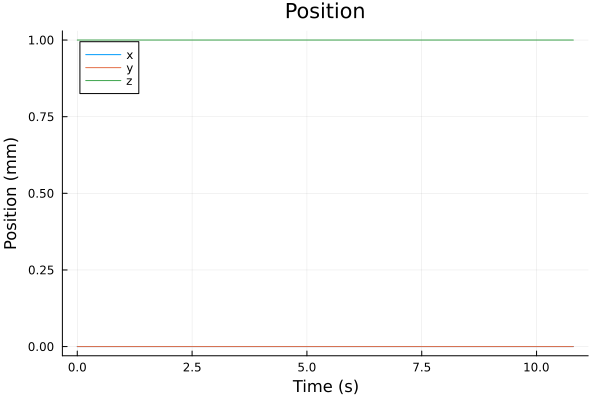

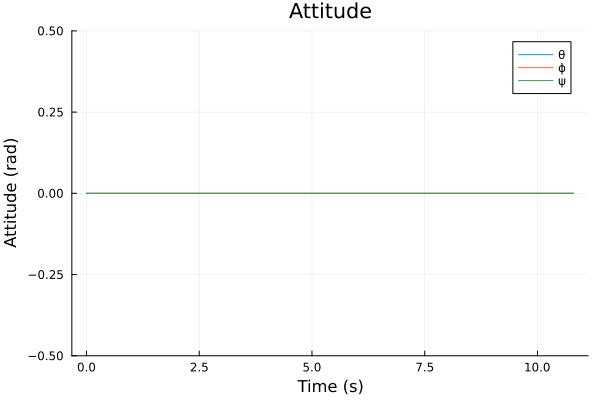

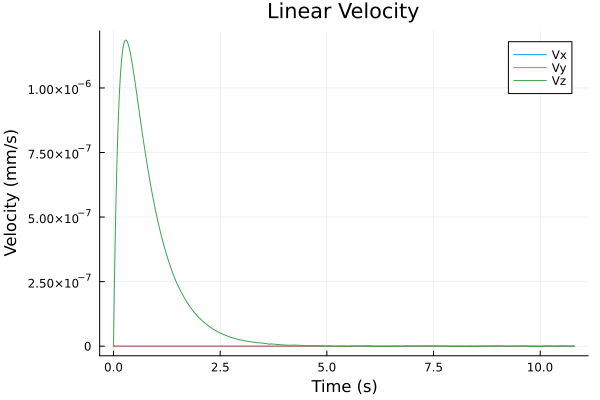

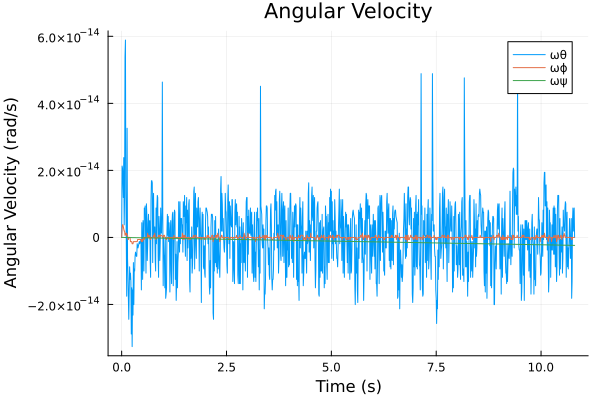

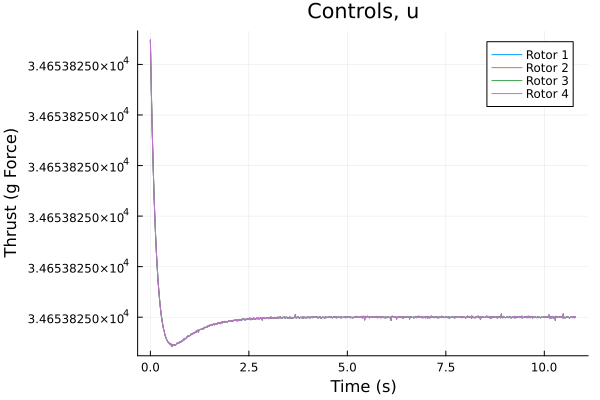

┌ Info: Listening on: 127.0.0.1:8704, thread id: 1
└ @ HTTP.Servers /Users/ashleykline/.julia/packages/HTTP/FSzDg/src/Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8704
└ @ MeshCat /Users/ashleykline/.julia/packages/MeshCat/ZB3jI/src/visualizer.jl:43


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("drone" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x64, 0x72, 0x6f, 0x6e, 0x65, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x64, 0x72, 0x6f, 0x6e, 0x65, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8704, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8704), "127.0.0.1", "8704", nothing, Sockets.TCPServer(RawFD(33) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x000000011e4fdaa0, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0)), MeshCat.AnimationContext[]))

In [13]:
    # -------------plotting/animation---------------------------
    Xm = mat_from_vec(X_sim)
    Um = mat_from_vec(U_sim)
    #x̂m= mat_from_vec(x̂)
   # Σm= mat_from_vec(Σ)
  
    plot1= plot(t_vec_sim,Xm[1:3,:]',title = "Position",
    xlabel = "Time (s)", ylabel = "Position (mm)",
    label = ["x" "y" "z"])

    #plot!(plot1,t_vec_sim, x̂m[1:3,:]', label=["Estimated x" "Estimated y" "Estimated z"], linestyle=:dash, legend=:right)
    display(plot1)

#     display(plot(t_vec_sim,Xm[1:3,:]',title = "Position",
#             xlabel = "Time (s)", ylabel = "Position (m)",
#             label = ["x" "y" "z"]))
     
    plot2= plot(t_vec_sim,Xm[7:9,:]', title = "Attitude",
    xlabel = "Time (s)", ylabel = "Attitude (rad)", ylimits=(-0.5,0.5),
    label = ["θ" "ϕ" "ψ"])

    #plot!(plot2,t_vec_sim, x̂m[7:9,:]',label=["Estimated θ" "Estimated ϕ" "Estimated ψ"], linestyle=:dash)
    display(plot2)

    plot3= plot(t_vec_sim,Xm[4:6,:]', title = "Linear Velocity",
    xlabel = "Time (s)", ylabel = "Velocity (mm/s)",
    label = ["Vx" "Vy" "Vz"])

    #plot!(plot3,t_vec_sim, x̂m[4:6,:]',label=["Estimated Vx" "Estimated Vy" "Estimated Vz"], linestyle=:dash)
    display(plot3)

    plot4= plot(t_vec_sim,Xm[10:12,:]', title = "Angular Velocity",
    xlabel = "Time (s)", ylabel = "Angular Velocity (rad/s)",
    label = ["ωθ" "ωϕ" "ωψ"])

   # plot!(plot4,t_vec_sim, x̂m[10:12,:]',label=["Estimated ωθ" "Estimated ωϕ" "Estimated ωψ"], linestyle=:dash)
    display(plot4)

    # display(plot(t_vec_sim,Xm[7:9,:]', title = "Attitude",
    #         xlabel = "Time (s)", ylabel = "Attitude (rad)", ylimits=(-0.5,0.5),
    #         label = ["Roll" "Pitch" "Yaw"])) 
    display(plot(t_vec_sim[1:end-1],Um',title = "Controls, u",
            xlabel = "Time (s)", ylabel= "Thrust (g Force)", label= ["Rotor 1" "Rotor 2" "Rotor 3" "Rotor 4"]))  


# mesh cat display
display(animate_quadrotor(X_sim, dt))

In [ ]:
#### error between target and simulation
error_gt_sim= [zeros(nx) for i= 1:N_sim]
state_gt= X̄
for i = 1:N_sim
    error_gt_sim[i]= abs.(state_gt.- X_sim[i])
end

# plotting
error_m= mat_from_vec(error_gt_sim)

plot5= plot(t_vec_sim, error_m[1:3,:]',
xlabel = "Time (s)", ylabel = "Error (m)",
label = ["x" "y" "z"])
display(plot5)
#title = "Position Absolute Error",

plot6= plot(t_vec_sim, error_m[7:9,:]',
xlabel = "Time (s)", ylabel = "Error (rad)",
label = ["θ" "ϕ" "ψ"])
display(plot6)
#title = "Attitude Absolute Error",

plot7= plot(t_vec_sim, error_m[4:6,:]',
xlabel = "Time (s)", ylabel = "Error (m/s)",
label = ["Vx" "Vy" "Vz"])
display(plot7)
#title = "Linear Velocity Absolute Error",
    
plot8= plot(t_vec_sim, error_m[10:12,:]',
xlabel = "Time (s)", ylabel = "Error (rad/s)",
label = ["ωθ" "ωy" "ωz"])
display(plot8)
#title = "Angular Velocity Absolute Error",



In [ ]:
#### looking at the wind state
wind_m= mat_from_vec(wind_velocity_sim)
est_wind_m= mat_from_vec(estimated_wind)

plot9= plot(t_vec_sim[1:end-1], wind_m[:,1:end-1]',
xlabel = "Time (s)", ylabel = "Wind Velocity (m/s)",
label = ["x" "y" "z"], legend=:right)
plot!(plot9,t_vec_sim[1:end-1], est_wind_m[:,1:end-1]',label=["Estimated x" "Estimated y" "Estimated z"], linestyle=:dash)
display(plot9)
#title = "Wind Disturbance Model",
